In [2]:
import numpy as np
import os
import pandas as pd
import random
import scipy.io as sio
import matplotlib.pyplot as plt
from scipy.stats import zscore
from sklearn import svm
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

Loading Data and Reshape it to My Desire Format

In [3]:
def read_files_function(sub_file_dir):
    # Input: file direction
    # Output: data: EEG Data (num_trials(2048)*num_channels(64)*trial_length(240)), 
    #               trial_inf: trials' tag (num_trials(2048)*3 (3=number of image classifiers))
    
    # Check File Directory
    if os.path.exists(sub_file_dir):
        # Loading Data and Trials Information
        input_file = sio.loadmat(sub_file_dir)
        data_file = input_file['data_rej_channel_interpolated_timelocked'][0] #numpy
        trial_inf = data_file['trialinfo'][0] #numpy
        data = data_file['trial'][0] #numpy
        
    else:
        print("File Not Found!")
    
    return data, trial_inf

In [4]:
def reshape_data (data,trial_inf,num_image_catg,num_trial_pair_catg,analysis_idx):
    """
    Organizes and reshapes EEG data based on image category and trial information.
    Parameters:
    - data (np.ndarray): EEG signal data with shape (num_trials, num_channels, trial_length).
    - trial_inf (np.ndarray): Array with shape (num_trials, 3), holding trial tags (e.g., image classifiers like pairs, categories, supra-categories).
    - num_image_catg (int): Number of image categories for analysis.
    - num_trial_pair_catg (int): Expected number of trials per category for analysis.
    - analysis_idx (int): Index to use in `trial_inf` to filter by (0: pairs, 1: category, 2: supra-category).
    Returns:
    - np.ndarray: Reshaped EEG data array of shape (num_image_catg, num_trial_pair_catg, num_channels, trial_length).
    """
    
    # Initialize Parameters
    trial_len = data.shape[2]
    num_channel = data.shape[1]
    trial_data = np.zeros((num_image_catg, num_trial_pair_catg, num_channel, trial_len))
    
     # Reshape data based on category and trial information
    for i in range(num_image_catg):
        # Check if the number of trials matches the required amount
        idx = np.where(trial_inf[:, analysis_idx] == i + 1)[0].astype(int) 
        # Consider equal number of trials for all images and subjects
        if len(idx) > num_trial_pair_catg:
            # Randomly remove excess trials
            delte_trial_idx = random.sample(range(len(idx)), len(idx)-num_trial_pair_catg)
            idx = np.delete(idx, delte_trial_idx)
        # Store reshaped data for the current category
        trial_data[i,:,:,:] = data[idx,:,:]
           
    return trial_data

In [5]:
def extract_pseudo_trials(data, num_image_catg, num_pseudo_trials, num_trials_pair_pseudo_trials, num_channel, 
                          trial_len, num_trial_pair_catg, group_sub):  
    """"
    Divide trials to pseudo-trials and average over trials to increase signal-to-noise ratio (SNR).
    Parameters:
    - data (pd.DataFrame): Contains reshaped EEG data for each subject. Each row corresponds to a subject with 'Subject' and 'Data' columns.
    - num_image_catg (int): Number of image categories for analysis.
    - num_pseudo_trials (int): Number of pseudo-trials to create for each image category.
    - num_trials_pair_pseudo_trials (int): Number of trials within each pseudo-trial group.
    - num_channel (int): Number of EEG channels.
    - trial_len (int): Time length of each trial.
    - num_trial_pair_catg (int): Number of trials available for each image category.
    - group_sub (List[int]): List of subject indices grouped by age or condition (e.g., old/young).

    Returns:
    - np.ndarray: Pseudo-trial data array of shape 
                  (num_image_catg, num_pseudo_trials * len(group_sub), num_channel, trial_len).
    """
    # Initialize the output array to hold averaged pseudo-trial data
    pseudo_trial_data = np.zeros((num_image_catg, num_pseudo_trials*len(group_sub), num_channel, trial_len))
    # Loop over each subject in the group
    for sub_index, sub_id in enumerate(group_sub):
        # Extract the EEG data for the current subject from the DataFrame
        image_data = data.loc[data['Subject'] == sub_id + 1, 'Data'].values[0]
        count = sub_index * num_pseudo_trials  # Index for storing the subject's data in the output

        # Process each image category for the current subject
        for image in range(num_image_catg):
            print(f"Subject: {sub_id}, Image Category: {image + 1}")

            # Step 1: Shuffle and split trials into groups for creating pseudo-trials
            trials = np.arange(num_trial_pair_catg)  # Create a range of trial indices
            np.random.shuffle(trials)  # Shuffle the trials to randomize grouping
            selected_trials = np.array(np.split(trials, num_trials_pair_pseudo_trials), dtype=int)

            # Step 2: Average trials within each pseudo-trial group to increase SNR
            for j in range(num_pseudo_trials):
                pseudo_trial_data[image, count + j, :, :] = np.mean(image_data[image, selected_trials[:, j], :, :], axis=0)
    
    return pseudo_trial_data

In [6]:
def eeg_classification(num_permutation, group_sub, group_num, img_index, trial_len_reduced, df_subject_data, 
                       num_image, num_pseudo_trials, num_trials_pair_pseudo_trials, num_channel, trial_len, num_trial_pair_image):
    
    """
    Classifies EEG data based on image categories and time points, using an SVM model

    Parameters:
    - num_permutation (int): Number of permutations to create pseudo-trials.
    - group_sub (List[int]): Subject group indices.
    - group_num (int): Number of subjects in each group.
    - img_index (List[int]): Indices of selected image categories.
    - trial_len_reduced (int): Reduced length of trials for faster analysis.
    - df_subject_data (pd.DataFrame): Dataframe containing subject-specific EEG data.
    - num_image (int): Number of image categories.
    - num_pseudo_trials (int): Number of pseudo-trials to create for each image category.
    - num_trials_pair_pseudo_trials (int): Number of trials per pseudo-trial.
    - num_channel (int): Number of EEG channels.
    - trial_len (int): Full time length of each trial.
    - num_trial_pair_image (int): Number of trials available per image category.

    Returns:
    - np.ndarray: Accuracy scores array with shape (num_permutation, len(img_index), len(img_index), trial_len_reduced).
    """
    # Initialize the accuracy results array
    Acc = np.zeros((num_permutation, len(img_index), len(img_index), trial_len_reduced))
     # Main loop over permutations
    for perm in range(num_permutation):
        # Step 1: Generate pseudo-trials
        pseudo_trial_data = extract_pseudo_trials(df_subject_data, num_image, num_pseudo_trials, num_trials_pair_pseudo_trials, num_channel, 
                                                trial_len, num_trial_pair_image, group_sub) #(num_image_catg, num_pseudo_trials * len(group_sub), num_channel, trial_len)
        # Step 2: Iterate over image pairs for classification
        for i, img1 in enumerate(img_index):
            for j in range(i+1, len(img_index)):
                img2 = img_index[j]
                # Step 3: Loop through time points
                for time in range(trial_len_reduced):
                    print(f"Training Model on images {img1} and {img2} at time point {time}")
                    
                    # Define training and test data for the SVM model
                    train_image1 = pseudo_trial_data[img1, :, :, time]
                    train_image2 = pseudo_trial_data[img2, :, :, time]     
                    training_data = np.concatenate((train_image1,train_image2), axis=0)
                    
                    # Create training labels
                    label_train1 = np.ones((group_num*num_pseudo_trials,1)); 
                    label_train2 = np.ones((group_num*num_pseudo_trials,1))*2
                    training_label = np.concatenate((label_train1,label_train2), axis=0).ravel()
                    
                    # Split data into training and testing sets
                    X_train, X_test, y_train, y_test = train_test_split(training_data, training_label, test_size=0.3, random_state=109)
                    
                    # Step 4: Initialize and train SVM model
                    model = svm.SVC(kernel='linear')
                    model.fit(X_train, y_train)
                    
                    # Step 5: Predict and store accuracy for the current permutation, image pair, and time point
                    y_pred = model.predict(X_test)
                    Acc[perm, i, j, time] = metrics.accuracy_score(y_test, y_pred)

    return Acc                                  

Image Classification

In [ ]:
# Define variables
file_dir = 'D:\\UBC\\Courses\\Dataset\\EEG'
num_sub = 43
fs = 1000
num_image = 64
num_trial_pair_image = 32
num_pseudo_trials = 8
analysis_idx= 0 # pair images
num_trials_pair_pseudo_trials = int(num_trial_pair_image / num_pseudo_trials)  # Trials per pseudo-trial group

# Initialize lists to store subject data
all_subject_data = []
df_subject_data = pd.DataFrame()

# Process each subject's EEG data
for sub_id in range(num_sub):
    print(f"Subject {sub_id + 1}")
    
    # Step 1: Load subject's EEG data and stimulus order
    folder_name = f"sub{sub_id + 1:02d}"  # Format subject folder name
    sub_file_dir = os.path.join(file_dir, folder_name, 'stepxx_timelock.mat')  # File path for subject's EEG data
    data, trial_inf = read_files_function(sub_file_dir)  # Load data and trial information
    
    # Step 2: Reshape trials' data based on image indexes
    trial_data = reshape_data(data, trial_inf, num_image, num_trial_pair_image, analysis_idx)
    
    # Step 3: Normalize the trial data
    trial_data_normalized = zscore(trial_data, axis=-1)  # Z-score normalization across the last axis (time)
    
    # Step 4: Store normalized data
    subject_data = {
        'Subject': sub_id + 1,             # Subject identifier
        'Data': trial_data_normalized,     # Normalized EEG data
    }
    all_subject_data.append(subject_data)  # Append dictionary to list
    
# Convert list of subject data dictionaries to a DataFrame
df_subject_data = pd.DataFrame(all_subject_data)


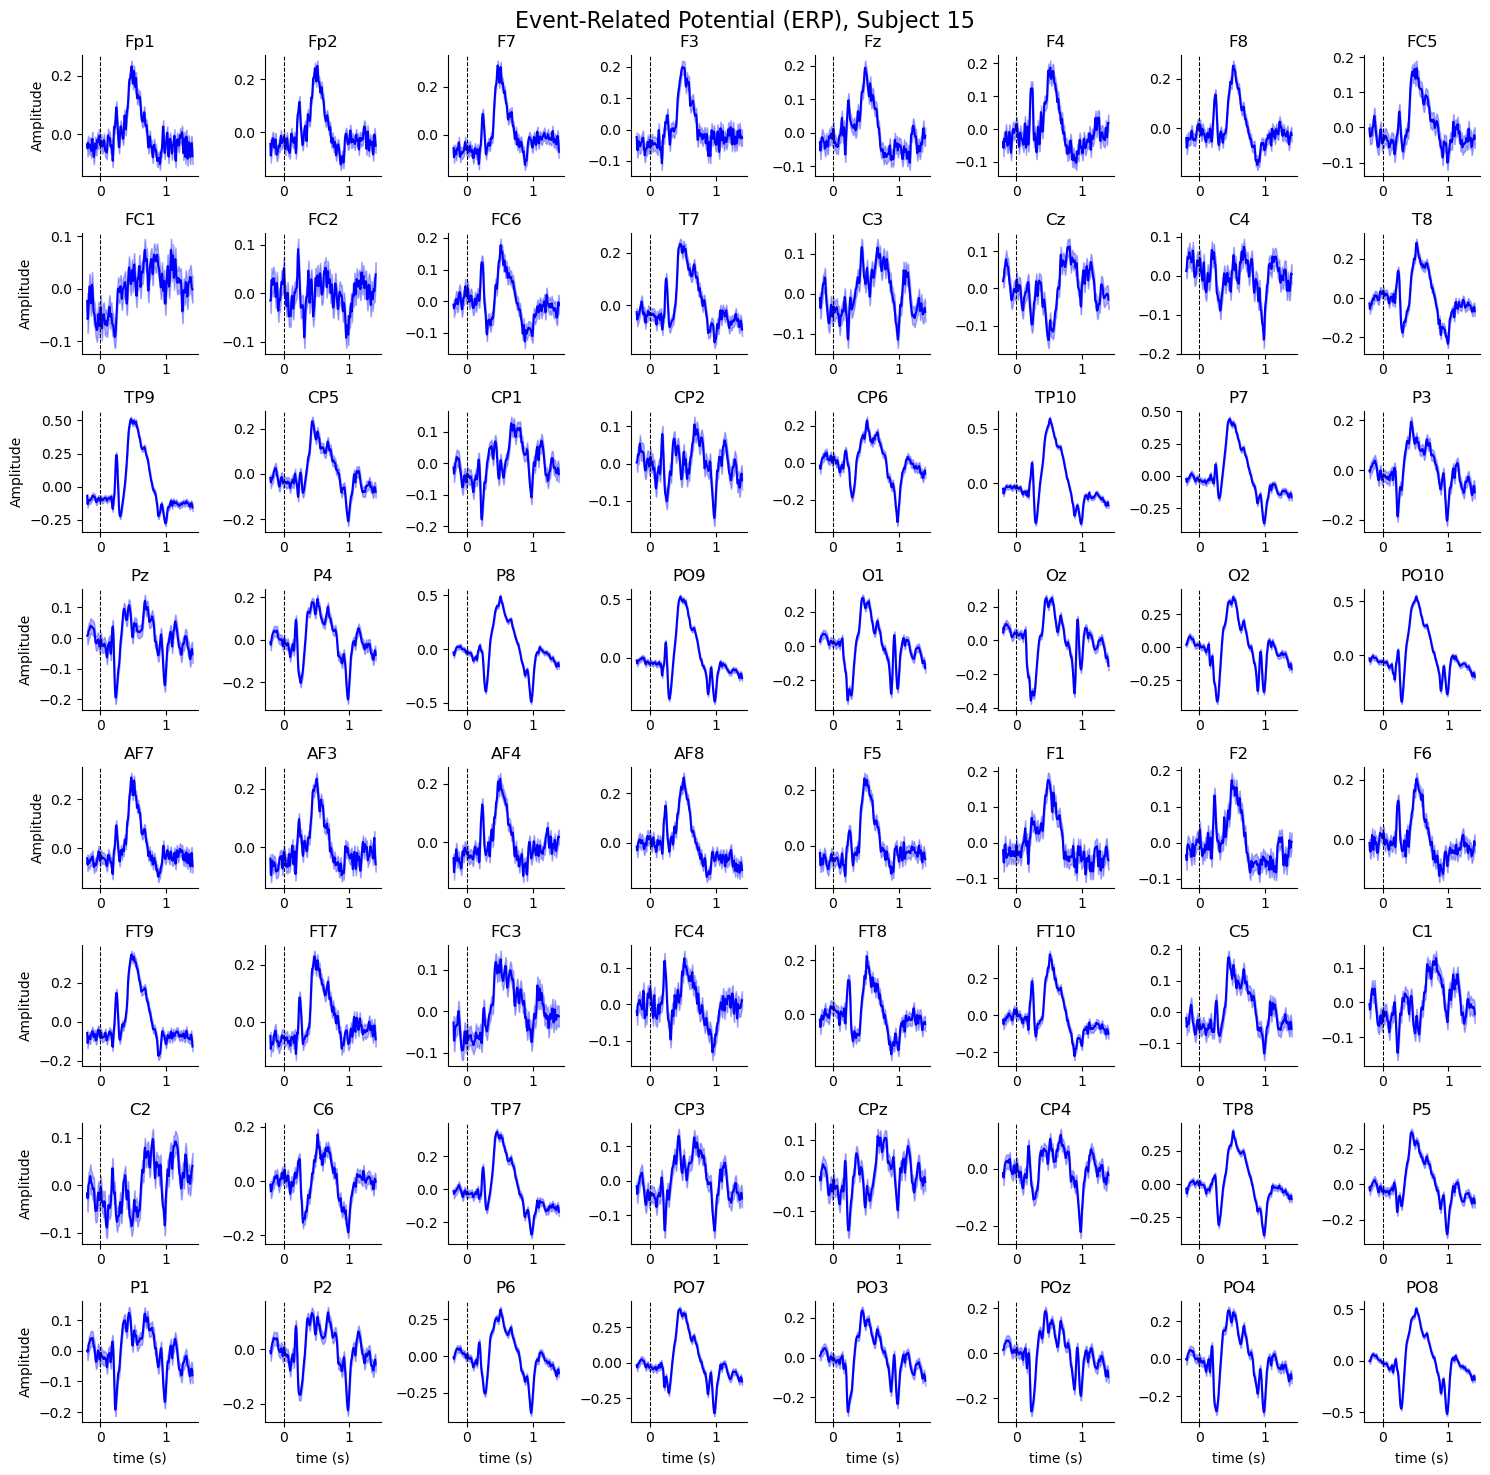

In [ ]:
# Plot ERP to check accuracy
# Channel names for each EEG channel (64 total)
channel_names = ['Fp1','Fp2','F7','F3','Fz','F4','F8','FC5','FC1','FC2','FC6','T7','C3','Cz','C4','T8','TP9','CP5','CP1','CP2','CP6','TP10',
                 'P7','P3','Pz','P4','P8','PO9','O1','Oz','O2','PO10','AF7','AF3','AF4','AF8','F5','F1','F2','F6','FT9','FT7','FC3','FC4',
                 'FT8','FT10','C5','C1','C2','C6','TP7','CP3','CPz','CP4','TP8','P5','P1','P2','P6','PO7','PO3','POz','PO4','PO8']
selected_sub_idx = 15   #Index of the subject data to be plotted
selected_sub_data = df_subject_data.loc[selected_sub_idx,'Data']   #Extract selected subject data
selected_sub_data_reshape = np.reshape(selected_sub_data, (64*32,64,240))    # Reshape to (all trials, channels, time points)
count = 0

# Set up figure with subplots for each channel
fig, ax = plt.subplots(8, 8, figsize=(15, 15))
time = np.linspace(-0.2, 1.4, 240)  # Time points for x-axis

for i in range(8):
   for j in range(8):
         # Calculate mean and standard deviation across trials for the current channel
        mean_data = np.mean(selected_sub_data_reshape[:,count,:], axis=0)
        std_data = np.std(selected_sub_data_reshape[:,count,:], axis=0)/np.sqrt(selected_sub_data_reshape.shape[0])  

        ax[i,j].plot(time, mean_data, color='blue', label='Mean')  # Plot mean line
        ax[i,j].fill_between(time, mean_data - std_data, mean_data + std_data, color='blue', alpha=0.3, label='Mean ± Std')  # Shaded area
        ax[i,j].axvline(0, color='black', linestyle='--', linewidth=0.75)

        if i == 7: ax[i,j].set_xlabel('time (s)')
        if j == 0: ax[i,j].set_ylabel('Amplitude')
        ax[i,j].set_title(channel_names[i*8+j])
        
        ax[i,j].spines['right'].set_visible(False)
        ax[i,j].spines['top'].set_visible(False)

        count += 1 # Move to the next channel


plt.tight_layout() 
fig.suptitle(f'Event-Related Potential (ERP), Subject {selected_sub_idx}', fontsize=16)
plt.subplots_adjust(top=0.95)  # Adjust space for the main title 


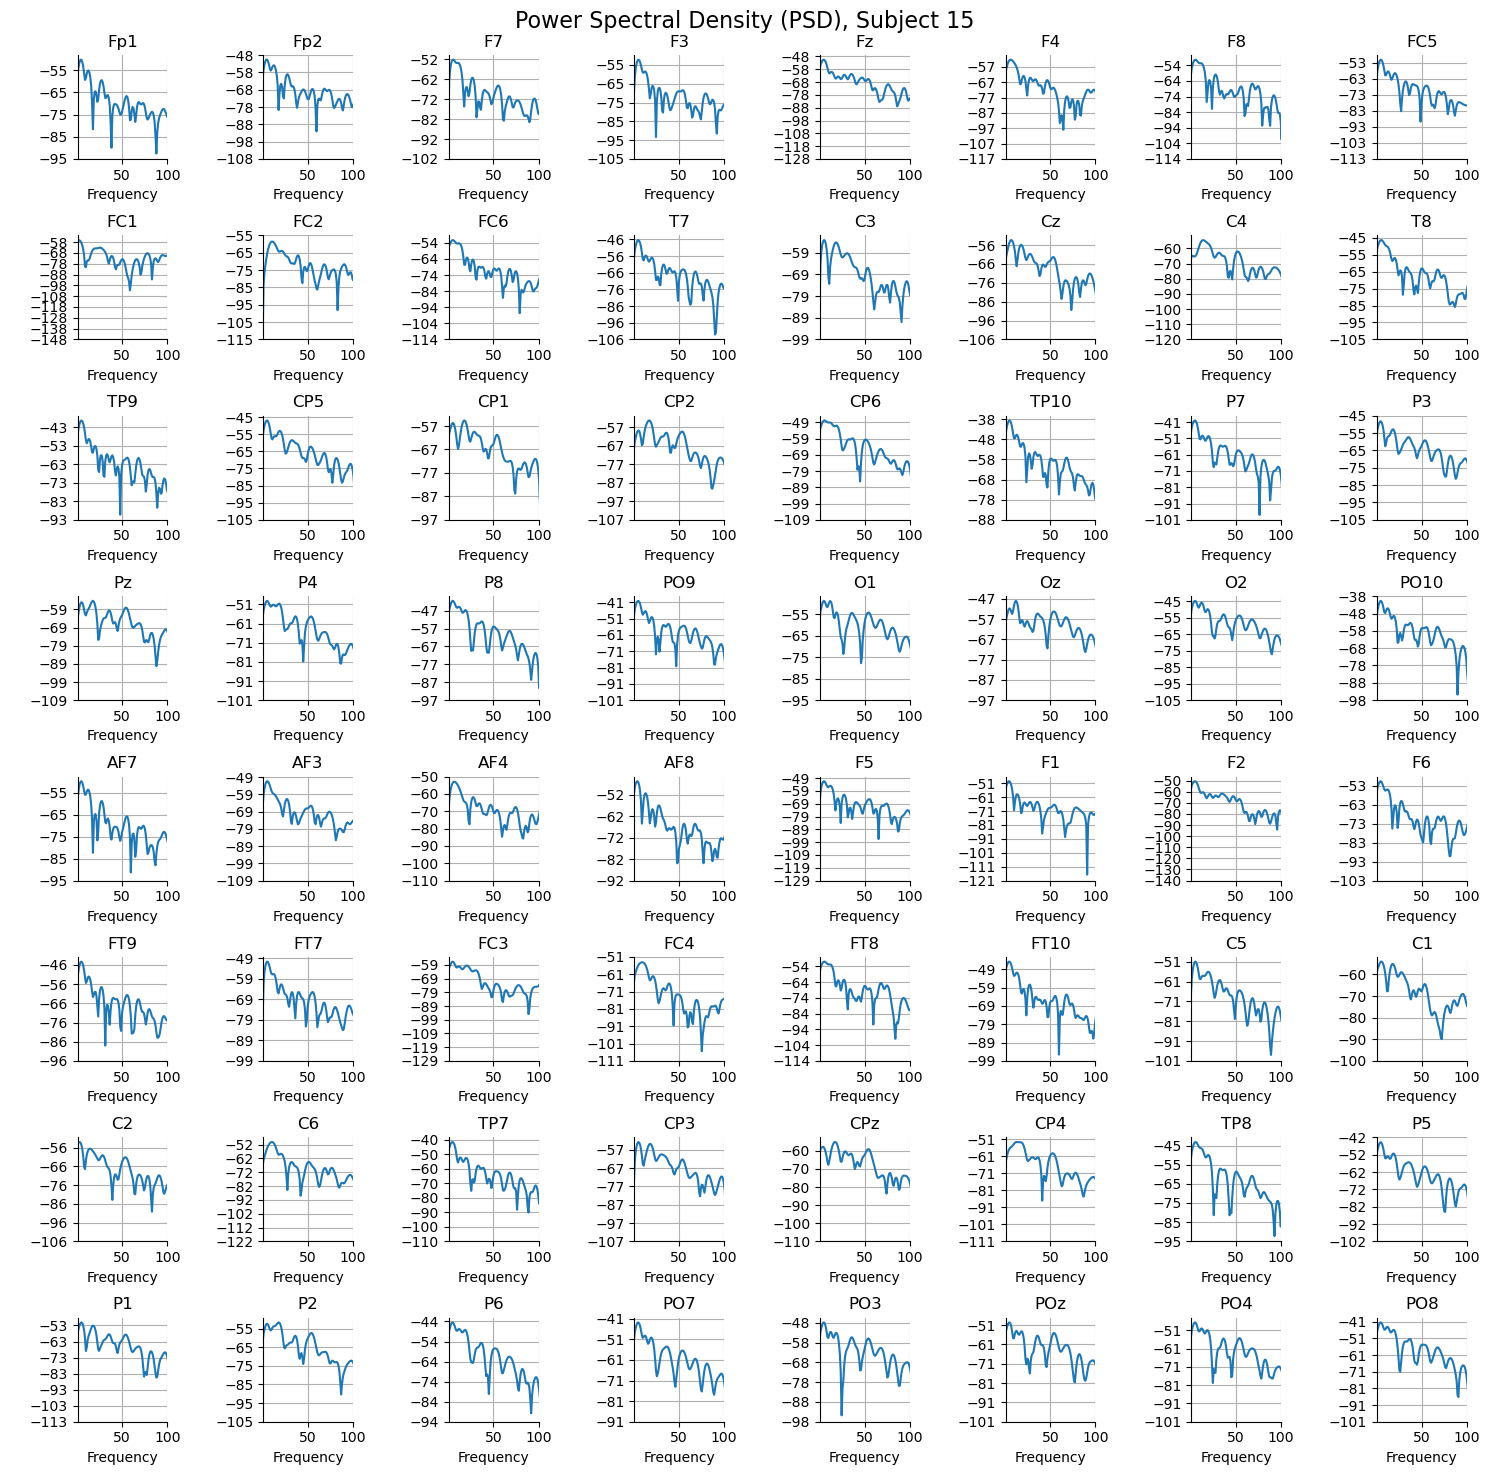

In [ ]:
# Plot PSD to check accuracy
selected_sub_idx = 15   #Index of the subject data to be plotted
selected_sub_data = df_subject_data.loc[selected_sub_idx,'Data']   #Extract selected subject data
selected_sub_data_reshape = np.reshape(selected_sub_data, (64*32,64,240))    # Reshape to (all trials, channels, time points)
count = 0

# Set up figure with subplots for each channel
fig, ax = plt.subplots(8, 8, figsize=(15, 15))
time = np.linspace(-0.2, 1.4, 240)  # Time points for x-axis

for i in range(8):
   for j in range(8):
         # Calculate mean and standard deviation across trials for the current channel
        mean_data = np.mean(selected_sub_data_reshape[:,count,:], axis=0)
        ax[i,j].psd(mean_data, NFFT=1024, Fs=1000, noverlap=100, scale_by_freq=True)

        ax[i,j].set_title(channel_names[i*8+j])
        
        ax[i,j].spines['right'].set_visible(False)
        ax[i,j].spines['top'].set_visible(False)
        
        ax[i,j].set_xlim(-40,-130)
        ax[i,j].set_xlim(0.5,100)
        ax[i, j].set_ylabel(' ')
        count += 1 # Move to the next channel


plt.tight_layout() 
fig.suptitle(f'Power Spectral Density (PSD), Subject {selected_sub_idx}', fontsize=16)
plt.subplots_adjust(top=0.95)  # Adjust space for the main title 



Time-Resolved EEG Classification

In [ ]:
num_permutation = 1
group1_sub = np.arange(1,20+1); group1_num = len(group1_sub)
group2_sub = np.arange(21,41+1); group2_num = len(group2_sub)
numbers = list(range(1,num_image))
seleted_img_index = random.sample(numbers, num_image//2) # number of category
trial_len = 240
trial_len_reduced = int(trial_len/2)
num_channel = 64

Acc1 = eeg_classification(num_permutation, group1_sub, group1_num, seleted_img_index, trial_len_reduced, df_subject_data, 
                       num_image, num_pseudo_trials, num_trials_pair_pseudo_trials, num_channel, trial_len, num_trial_pair_image)
np.save('Acc_First_Group_half_images.npy',Acc1) 

Acc2 = eeg_classification(num_permutation, group2_sub, group2_num, seleted_img_index, trial_len_reduced, df_subject_data, 
                       num_image, num_pseudo_trials, num_trials_pair_pseudo_trials, num_channel, trial_len, num_trial_pair_image)
np.save('Acc_Second_Group_half_images.npy',Acc2)   

In [ ]:
num_permutation = 1
num_channel = 64
trial_len = 240                  
trial_len_reduced = int(trial_len / 2)  

# Define subject groups: Group 1 has subjects 1-20, Group 2 has subjects 21-41
group1_sub = np.arange(1, 20 + 1)  
group1_num = len(group1_sub)       
group2_sub = np.arange(21, 41 + 1) 
group2_num = len(group2_sub)       

# Generate a list of all image indices (1 to num_image) and randomly select half of them
numbers = list(range(1, num_image))                          
seleted_img_index = random.sample(numbers, num_image // 2)  

# Perform EEG classification for Group 1 using the selected image indices and save the results
Acc1 = eeg_classification(
    num_permutation, group1_sub, group1_num, seleted_img_index, 
    trial_len_reduced, df_subject_data, num_image, num_pseudo_trials, 
    num_trials_pair_pseudo_trials, num_channel, trial_len, num_trial_pair_image
)
np.save('Acc_First_Group_half_images.npy', Acc1)

# Perform EEG classification for Group 2 using the same settings and save the results
Acc2 = eeg_classification(
    num_permutation, group2_sub, group2_num, seleted_img_index, 
    trial_len_reduced, df_subject_data, num_image, num_pseudo_trials, 
    num_trials_pair_pseudo_trials, num_channel, trial_len, num_trial_pair_image
)
np.save('Acc_Second_Group_half_images.npy', Acc2)


In [3]:
#Loading the data
Acc1 = np.load("D:/UBC/Courses/Dataset/Acc_First_Group_half_images.npy")
Acc2 = np.load("D:/UBC/Courses/Dataset/Acc_Second_Group_half_images.npy")

In [7]:
# Initialize variables
num_permutation = 1 
acc1_time = np.zeros(trial_len_reduced)
acc2_time = np.zeros(trial_len_reduced)
acc1_ci = np.zeros(trial_len_reduced)
acc2_ci = np.zeros(trial_len_reduced)

# Iterate over all reduced trial time points
for time in range(trial_len_reduced):
    acc_values_perms1 = []  # List to store accuracy values for Group 1 at the current time point
    acc_values_perms2 = []  # List to store accuracy values for Group 2 at the current time point
    
    # Process each permutation for the current time point
    for perm in range(num_permutation):
        # Extract the upper triangular part of the accuracy matrix for Group 1
        upper_trig = np.triu(Acc1[perm, :, :, time], k=1)  # Exclude diagonal elements
        acc_values_perms1.extend(upper_trig[upper_trig != 0] * 100)  # Collect non-zero values and convert to percentages
        
        # Extract the upper triangular part of the accuracy matrix for Group 2
        upper_trig = np.triu(Acc2[perm, :, :, time], k=1)  # Exclude diagonal elements
        acc_values_perms2.extend(upper_trig[upper_trig != 0] * 100)  # Collect non-zero values and convert to percentages
    
    # Calculate mean accuracy and confidence intervals for Group 1
    acc1_time[time] = np.mean(acc_values_perms1)  # Mean accuracy for Group 1 at the current time
    acc1_ci[time] = (np.std(acc_values_perms1) / np.sqrt(len(acc_values_perms1))) * 1.96  # 95% confidence interval

    # Calculate mean accuracy and confidence intervals for Group 2
    acc2_time[time] = np.mean(acc_values_perms2)  # Mean accuracy for Group 2 at the current time
    acc2_ci[time] = (np.std(acc_values_perms2) / np.sqrt(len(acc_values_perms2))) * 1.96  # 95% confidence interval

# Generate a time vector corresponding to the reduced trial length
t = np.linspace(-0.2, 0.4, trial_len_reduced)  # Time range from -0.2s to 0.4s

# Identify the peak accuracy values and their corresponding times for both groups
acc1_peak_value = np.max(acc1_time)    
acc1_peak_time = t[np.argmax(acc1_time)] 
acc2_peak_value = np.max(acc2_time)    
acc2_peak_time = t[np.argmax(acc2_time)]

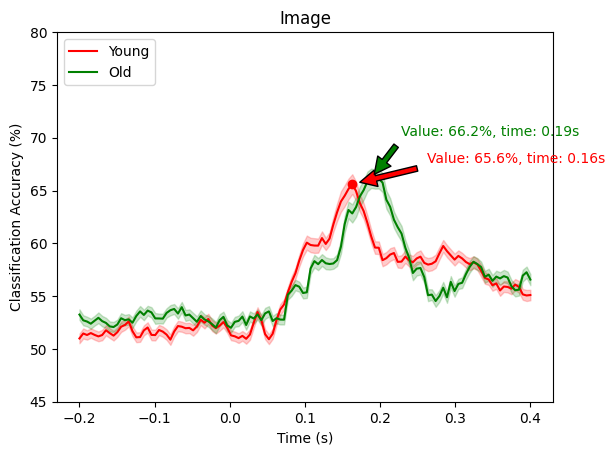

Text(0.5, 1.0, 'Image')

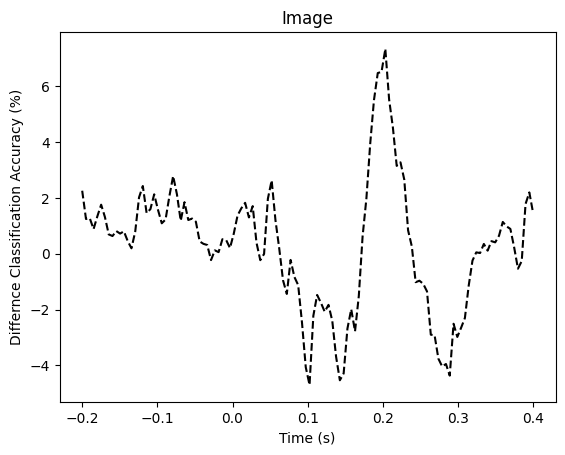

In [11]:
plt.figure()

# Plot the accuracy over time for the "Young" group (Group 1)
plt.plot(t, acc1_time, 'r', label='Young', linewidth=1.5)  # Plot mean accuracy for Group 1 in red
plt.fill_between(t, (acc1_time - acc1_ci), (acc1_time + acc1_ci), color='red', alpha=0.2)  # Add shaded confidence interval
plt.plot(acc1_peak_time, acc1_peak_value, 'ro')  # Mark the peak accuracy point with a red circle

# Annotate the peak accuracy value and time for the "Young" group
plt.annotate(
    f'Value: {acc1_peak_value:.1f}%, time: {acc1_peak_time:.2f}s',  # Annotation text with value and time
    xy=(acc1_peak_time, acc1_peak_value),  # Point to annotate (peak location)
    xytext=(acc1_peak_time + 0.1, acc1_peak_value + 2),  # Position of the annotation text
    arrowprops=dict(facecolor='red', shrink=0.1),  # Arrow properties
    color='red'  # Annotation text color
)

# Plot the accuracy over time for the "Old" group (Group 2)
plt.plot(t, acc2_time, 'g', label='Old', linewidth=1.5)  # Plot mean accuracy for Group 2 in green
plt.fill_between(t, (acc2_time - acc2_ci), (acc2_time + acc2_ci), color='green', alpha=0.2)  # Add shaded confidence interval
plt.plot(acc2_peak_time, acc2_peak_value, 'go')  # Mark the peak accuracy point with a green circle

# Annotate the peak accuracy value and time for the "Old" group
plt.annotate(
    f'Value: {acc2_peak_value:.1f}%, time: {acc2_peak_time:.2f}s',  # Annotation text with value and time
    xy=(acc2_peak_time, acc2_peak_value),  # Point to annotate (peak location)
    xytext=(acc2_peak_time + 0.04, acc2_peak_value + 4),  # Position of the annotation text
    arrowprops=dict(facecolor='green', shrink=0.1),  # Arrow properties
    color='green'  # Annotation text color
)

# Add labels and title to the plot
plt.xlabel('Time (s)')  # X-axis label (time in seconds)
plt.ylabel('Classification Accuracy (%)')  # Y-axis label (accuracy in percentage)
plt.title('Image')  # Title of the plot

# Add a legend to differentiate between groups
plt.legend(loc='upper left')  # Position the legend in the upper-left corner

# Set the y-axis limits to provide better visualization
plt.ylim([45, 80])  # Y-axis range from 45% to 80%

# Display the plot
plt.show()



plt.figure()
plt.plot(t, acc2_time-acc1_time, '--k') #plot differnce accuracy
plt.xlabel('Time (s)')  # X-axis label (time in seconds)
plt.ylabel('Differnce Classification Accuracy (%)')  # Y-axis label (accuracy in percentage)
plt.title('Image')  # Title of the plot

Category Classification

In [ ]:
# Define variables
file_dir = 'D:\\UBC\\Courses\\Dataset\\EEG'
num_sub = 43
fs = 1000
num_image = 4
num_trial_pair_image = 32*16
#num_trial_pair_catg
num_pseudo_trials = 8*16
analysis_idx= 1 # pair category
num_trials_pair_pseudo_trials = int(num_trial_pair_image / num_pseudo_trials)  # Trials per pseudo-trial group

# Initialize lists to store subject data
all_subject_data = []
df_subject_data = pd.DataFrame()

# Process each subject's EEG data
for sub_id in range(num_sub):
    print(f"Subject {sub_id + 1}")
    
    # Step 1: Load subject's EEG data and stimulus order
    folder_name = f"sub{sub_id + 1:02d}"  # Format subject folder name
    sub_file_dir = os.path.join(file_dir, folder_name, 'stepxx_timelock.mat')  # File path for subject's EEG data
    data, trial_inf = read_files_function(sub_file_dir)  # Load data and trial information
    
    # Step 2: Reshape trials' data based on image indexes
    trial_data = reshape_data(data, trial_inf, num_image, num_trial_pair_image, analysis_idx)
    
    # Step 3: Normalize the trial data
    trial_data_normalized = zscore(trial_data, axis=-1)  # Z-score normalization across the last axis (time)
    
    # Step 4: Store normalized data
    subject_data = {
        'Subject': sub_id + 1,             # Subject identifier
        'Data': trial_data_normalized,     # Normalized EEG data
    }
    all_subject_data.append(subject_data)  # Append dictionary to list
    
# Convert list of subject data dictionaries to a DataFrame
df_subject_data2 = pd.DataFrame(all_subject_data)


In [ ]:
# Set parameters for EEG classification
num_permutation = 1  
num_image = 4 

# Define subject groups
group1_sub = np.arange(1, 20 + 1)
group1_num = len(group1_sub)  
group2_sub = np.arange(21, 41 + 1) 
group2_num = len(group2_sub)

# Image selection
seleted_img_index = range(num_image)

# Trial parameters
trial_len = 240  
trial_len_reduced = int(trial_len / 2)  # Reduced trial length (half the original)
num_channel = 64 

# Pseudo-trial parameters
num_trial_pair_image = 32 * 16  # Total number of trial pairs for each image category
num_pseudo_trials = 8 * 16  # Total number of pseudo-trials
num_trials_pair_pseudo_trials = int(num_trial_pair_image / num_pseudo_trials)  # Number of trials per pseudo-trial group

# Perform EEG classification for Group 1
Acc1 = eeg_classification(
    num_permutation,  # Number of permutations
    group1_sub,       # Subjects in Group 1
    group1_num,       # Number of subjects in Group 1
    seleted_img_index,  # Selected image indices for analysis
    trial_len_reduced,  # Reduced trial length for classification
    df_subject_data2,   # EEG data for analysis
    num_image,          # Number of image categories
    num_pseudo_trials,  # Total pseudo-trials
    num_trials_pair_pseudo_trials,  # Trials per pseudo-trial group
    num_channel,        # Number of EEG channels
    trial_len,          # Total trial length
    num_trial_pair_image  # Total trial pairs per image category
)
np.save('Acc_First_Group_Category.npy', Acc1)  # Save accuracy results for Group 1

# Perform EEG classification for Group 2
Acc2 = eeg_classification(
    num_permutation,  # Number of permutations
    group2_sub,       # Subjects in Group 2
    group2_num,       # Number of subjects in Group 2
    seleted_img_index,  # Selected image indices for analysis
    trial_len_reduced,  # Reduced trial length for classification
    df_subject_data2,   # EEG data for analysis
    num_image,          # Number of image categories
    num_pseudo_trials,  # Total pseudo-trials
    num_trials_pair_pseudo_trials,  # Trials per pseudo-trial group
    num_channel,        # Number of EEG channels
    trial_len,          # Total trial length
    num_trial_pair_image  # Total trial pairs per image category
)
np.save('Acc_Second_Group_Category.npy', Acc2)  # Save accuracy results for Group 2


In [ ]:
# Initialize arrays to store mean accuracy and confidence intervals for both groups
acc1_time = np.zeros(trial_len_reduced)  # Mean accuracy over time for Group 1
acc2_time = np.zeros(trial_len_reduced)  # Mean accuracy over time for Group 2
acc1_ci = np.zeros(trial_len_reduced)    # Confidence interval over time for Group 1
acc2_ci = np.zeros(trial_len_reduced)    # Confidence interval over time for Group 2

# Iterate over all time points in the reduced trial length
for time in range(trial_len_reduced):
    acc_values_perms1 = []  # List to store accuracy values for Group 1 at the current time point
    acc_values_perms2 = []  # List to store accuracy values for Group 2 at the current time point
    
    # Process each permutation for the current time point
    for perm in range(num_permutation):
        # Extract the upper triangular matrix of accuracies for Group 1
        upper_trig = np.triu(Acc1[perm, :, :, time], k=1)  # Get the upper triangle excluding the diagonal
        acc_values_perms1.extend(upper_trig[upper_trig != 0] * 100)  # Collect non-zero values and convert to percentages
        
        # Extract the upper triangular matrix of accuracies for Group 2
        upper_trig = np.triu(Acc2[perm, :, :, time], k=1)  # Get the upper triangle excluding the diagonal
        acc_values_perms2.extend(upper_trig[upper_trig != 0] * 100)  # Collect non-zero values and convert to percentages
    

    acc1_time[time] = np.mean(acc_values_perms1)  # Mean accuracy for Group 1 at the current time
    acc1_ci[time] = (np.std(acc_values_perms1) / np.sqrt(len(acc_values_perms1))) * 1.96  # 95% confidence interval


    acc2_time[time] = np.mean(acc_values_perms2)  # Mean accuracy for Group 2 at the current time
    acc2_ci[time] = (np.std(acc_values_perms2) / np.sqrt(len(acc_values_perms2))) * 1.96  # 95% confidence interval

# Generate a time vector
t = np.linspace(-0.2, 0.4, trial_len_reduced) 

# Identify the peak accuracy values and their corresponding times for Group 1
acc1_peak_value = np.max(acc1_time)  # Maximum accuracy for Group 1
acc1_peak_time = t[np.argmax(acc1_time)]  # Time point of the peak accuracy for Group 1

# Identify the peak accuracy values and their corresponding times for Group 2
acc2_peak_value = np.max(acc2_time)  # Maximum accuracy for Group 2
acc2_peak_time = t[np.argmax(acc2_time)]  # Time point of the peak accuracy for Group 2

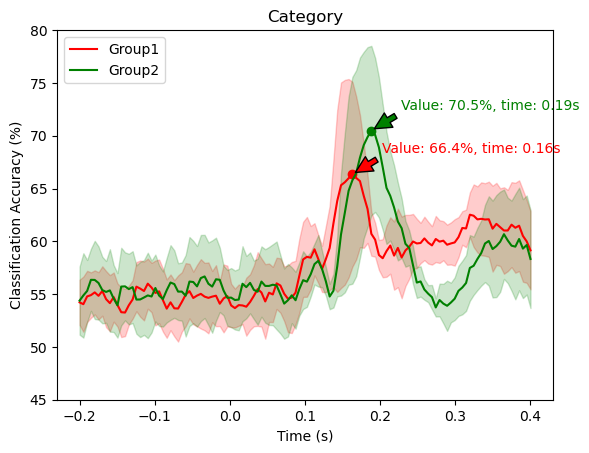

In [ ]:
plt.figure()

# Plot the classification accuracy over time for Group 1 ("Young")
plt.plot(t, acc1_time, 'r', label='Young', linewidth=1.5)  # Plot mean accuracy for Group 1 in red
plt.fill_between(t, (acc1_time - acc1_ci), (acc1_time + acc1_ci), color='red', alpha=0.2)  # Add shaded confidence interval
plt.plot(acc1_peak_time, acc1_peak_value, 'ro')  # Highlight the peak accuracy point with a red circle

# Annotate the peak accuracy value and its corresponding time for Group 1
plt.annotate(
    f'Value: {acc1_peak_value:.1f}%, time: {acc1_peak_time:.2f}s',  # Annotation text with peak value and time
    xy = (acc1_peak_time, acc1_peak_value),  # Coordinates for the annotation arrow
    xytext = (acc1_peak_time + 0.04, acc1_peak_value + 2),  # Position of the annotation text
    arrowprops = dict(facecolor='red', shrink=0.1), 
    color = 'red' 
)

# Plot the classification accuracy over time for Group 2 ("Old")
plt.plot(t, acc2_time, 'g', label='Old', linewidth=1.5)  # Plot mean accuracy for Group 2 in green
plt.fill_between(t, (acc2_time - acc2_ci), (acc2_time + acc2_ci), color='green', alpha=0.2)  # Add shaded confidence interval
plt.plot(acc2_peak_time, acc2_peak_value, 'go')  # Highlight the peak accuracy point with a green circle

# Annotate the peak accuracy value and its corresponding time for Group 2
plt.annotate(
    f'Value: {acc2_peak_value:.1f}%, time: {acc2_peak_time:.2f}s',  # Annotation text with peak value and time
    xy=(acc2_peak_time, acc2_peak_value),  # Coordinates for the annotation arrow
    xytext=(acc2_peak_time + 0.04, acc2_peak_value + 2),  # Position of the annotation text
    arrowprops=dict(facecolor='green', shrink=0.1), 
    color='green'
)


plt.xlabel('Time (s)')
plt.ylabel('Classification Accuracy (%)')
plt.title('Category')
plt.legend(loc='upper left')
plt.ylim([45, 80])
plt.show()

Supra Classification

In [ ]:
# Define variables
file_dir = 'D:\\UBC\\Courses\\Dataset\\EEG'
num_sub = 43
fs = 1000
num_image = 2
num_trial_pair_image = 32*32
#num_trial_pair_catg
num_pseudo_trials = 8*32
analysis_idx= 2 # pair supra category
num_trials_pair_pseudo_trials = int(num_trial_pair_image / num_pseudo_trials)  # Trials per pseudo-trial group

# Initialize lists to store subject data
all_subject_data = []
df_subject_data = pd.DataFrame()

# Process each subject's EEG data
for sub_id in range(num_sub):
    print(f"Subject {sub_id + 1}")
    
    # Step 1: Load subject's EEG data and stimulus order
    folder_name = f"sub{sub_id + 1:02d}"  # Format subject folder name
    sub_file_dir = os.path.join(file_dir, folder_name, 'stepxx_timelock.mat')  # File path for subject's EEG data
    data, trial_inf = read_files_function(sub_file_dir)  # Load data and trial information
    
    # Step 2: Reshape trials' data based on image indexes
    trial_data = reshape_data(data, trial_inf, num_image, num_trial_pair_image, analysis_idx)
    
    # Step 3: Normalize the trial data
    trial_data_normalized = zscore(trial_data, axis=-1)  # Z-score normalization across the last axis (time)
    
    # Step 4: Store normalized data
    subject_data = {
        'Subject': sub_id + 1,             # Subject identifier
        'Data': trial_data_normalized,     # Normalized EEG data
    }
    all_subject_data.append(subject_data)  # Append dictionary to list
    
# Convert list of subject data dictionaries to a DataFrame
df_subject_data3 = pd.DataFrame(all_subject_data)


In [ ]:
num_permutation = 1
num_image = 2
seleted_img_index = range(num_image)  
trial_len = 240                       
trial_len_reduced = int(trial_len / 2)  # Reduced trial length (for specific analyses)
num_channel = 64 
# Calculate the number of trials per pseudo-trial group
num_trials_pair_pseudo_trials = int(num_trial_pair_image / num_pseudo_trials)


group1_sub = np.arange(1, 20 + 1)  # Subjects in Group 1 (IDs 1 to 20)
group1_num = len(group1_sub)       # Total number of subjects in Group 1
group2_sub = np.arange(21, 41 + 1) # Subjects in Group 2 (IDs 21 to 41)
group2_num = len(group2_sub)       # Total number of subjects in Group 2

                     
# Perform EEG classification for Group 1
Acc1 = eeg_classification(
    num_permutation,             # Number of permutations
    group1_sub,                  # Subject IDs for Group 1
    group1_num,                  # Number of subjects in Group 1
    seleted_img_index,           # Indices of selected image categories
    trial_len_reduced,           # Reduced trial length
    df_subject_data3,            # EEG data for Group 1
    num_image,                   # Number of image categories
    num_pseudo_trials,           # Number of pseudo-trials
    num_trials_pair_pseudo_trials, # Trials per pseudo-trial
    num_channel,                 # Number of EEG channels
    trial_len,                   # Total trial length
    num_trial_pair_image         # Total number of trial pairs per image category
)
# Save the classification results for Group 1 to a NumPy binary file
np.save('Acc_First_Group_SupraCategory.npy', Acc1)

# Perform EEG classification for Group 2
Acc2 = eeg_classification(
    num_permutation,             # Number of permutations
    group2_sub,                  # Subject IDs for Group 2
    group2_num,                  # Number of subjects in Group 2
    seleted_img_index,           # Indices of selected image categories
    trial_len_reduced,           # Reduced trial length
    df_subject_data3,            # EEG data for Group 2
    num_image,                   # Number of image categories
    num_pseudo_trials,           # Number of pseudo-trials
    num_trials_pair_pseudo_trials, # Trials per pseudo-trial
    num_channel,                 # Number of EEG channels
    trial_len,                   # Total trial length
    num_trial_pair_image         # Total number of trial pairs per image category
)
# Save the classification results for Group 2 to a NumPy binary file
np.save('Acc_Second_Group_SupraCategory.npy', Acc2)


In [ ]:
acc1_time = np.zeros(trial_len_reduced)  # Mean classification accuracy for Group 1 across time points
acc2_time = np.zeros(trial_len_reduced)  # Mean classification accuracy for Group 2 across time points
acc1_ci = np.zeros(trial_len_reduced)    # Confidence interval for Group 1 accuracy across time points
acc2_ci = np.zeros(trial_len_reduced)    # Confidence interval for Group 2 accuracy across time points

# Loop through each time point in the reduced trial length
for time in range(trial_len_reduced):
    acc_values_perms1 = []  # List to store accuracy values for Group 1 at the current time point
    acc_values_perms2 = []  # List to store accuracy values for Group 2 at the current time point
    
    # Process each permutation for the current time point
    for perm in range(num_permutation):
        # Extract the upper triangular matrix (excluding diagonal) of the accuracy data for Group 1
        upper_trig = np.triu(Acc1[perm, :, :, time], k=1)  # Get unique pairwise accuracies
        acc_values_perms1.extend(upper_trig[upper_trig != 0] * 100)  # Collect non-zero values and convert to percentage
        
        # Extract the upper triangular matrix (excluding diagonal) of the accuracy data for Group 2
        upper_trig = np.triu(Acc2[perm, :, :, time], k=1)  # Get unique pairwise accuracies
        acc_values_perms2.extend(upper_trig[upper_trig != 0] * 100)  # Collect non-zero values and convert to percentage
    
    # Calculate mean accuracy and confidence interval for Group 1 at the current time point
    acc1_time[time] = np.mean(acc_values_perms1)  
    acc1_ci[time] = (np.std(acc_values_perms1) / np.sqrt(len(acc_values_perms1))) * 1.96  
    
    # Calculate mean accuracy and confidence interval for Group 2 at the current time point
    acc2_time[time] = np.mean(acc_values_perms2)
    acc2_ci[time] = (np.std(acc_values_perms2) / np.sqrt(len(acc_values_perms2))) * 1.96 

t = np.linspace(-0.2, 0.4, trial_len_reduced) 

acc1_peak_value = np.max(acc1_time)  # Find the maximum accuracy value for Group 1
acc1_peak_time = t[np.argmax(acc1_time)]  # Find the time point corresponding to the maximum accuracy for Group 1

acc2_peak_value = np.max(acc2_time)  # Find the maximum accuracy value for Group 2
acc2_peak_time = t[np.argmax(acc2_time)]  # Find the time point corresponding to the maximum accuracy for Group 2


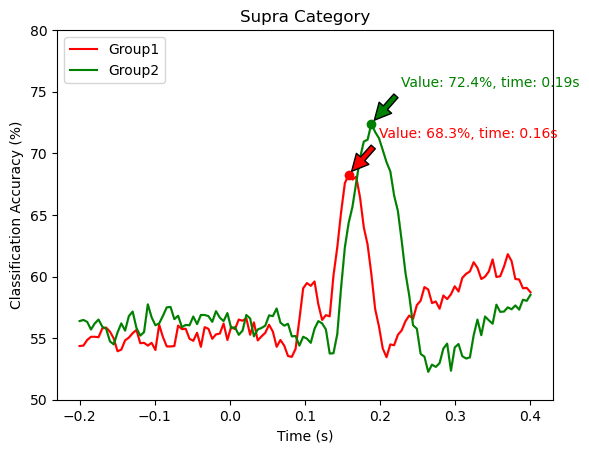

In [ ]:
plt.figure()

# Plot the classification accuracy over time for Group 1
plt.plot(t, acc1_time, 'r', label='Group1', linewidth=1.5) 
plt.fill_between(t, (acc1_time - acc1_ci), (acc1_time + acc1_ci), color='red', alpha=0.2)
plt.plot(acc1_peak_time, acc1_peak_value, 'ro') 

# Annotate the peak accuracy value and its corresponding time for Group 1
plt.annotate(
    f'Value: {acc1_peak_value:.1f}%, time: {acc1_peak_time:.2f}s',  
    xy=(acc1_peak_time, acc1_peak_value),
    xytext=(acc1_peak_time + 0.04, acc1_peak_value + 3),  
    arrowprops=dict(facecolor='red', shrink=0.1),
    color='red'
)

# Plot the classification accuracy over time for Group 2
plt.plot(t, acc2_time, 'g', label='Group2', linewidth=1.5)  
plt.fill_between(t, (acc2_time - acc2_ci), (acc2_time + acc2_ci), color='green', alpha=0.2) 
plt.plot(acc2_peak_time, acc2_peak_value, 'go') 

# Annotate the peak accuracy value and its corresponding time for Group 2
plt.annotate(
    f'Value: {acc2_peak_value:.1f}%, time: {acc2_peak_time:.2f}s',
    xy=(acc2_peak_time, acc2_peak_value),
    xytext=(acc2_peak_time + 0.04, acc2_peak_value + 3), 
    arrowprops=dict(facecolor='green', shrink=0.1), 
    color='green'
)


plt.xlabel('Time (s)')
plt.ylabel('Classification Accuracy (%)')
plt.title('Supra Category')
plt.legend(loc='upper left')
plt.ylim([50, 80])
plt.show()


Classify Old and Young, Using EEG signal.


In [ ]:
# Define experimental parameters
num_image = 64  # Number of image categories
num_trials = 2048 // 4  # Number of trials for each subject, after averaging every four trials
num_selected_trials = 10  # Number of trials randomly selected for analysis per subject
num_sub = 41
num_permutation = 1  # Number of permutations for the analysis
trial_len = 240  # Total length of each trial (number of time points)
trial_len_reduced = int(trial_len / 2)  # Reduced trial length for specific analysis (half of original)
num_channel = 64  # Number of EEG channels
file_dir = 'D:\\UBC\\Courses\\Dataset\\EEG'  # Directory containing the EEG dataset
fs = 1000  # Sampling frequency (Hz)

# Define subject groups
group1_sub = np.arange(1, 20 + 1)  
group1_num = len(group1_sub)
group2_sub = np.arange(21, 41 + 1)
group2_num = len(group2_sub)

# Initialize arrays to store EEG data for all subjects
# Shape: (total trials across subjects, number of images, reduced trial length)
Data_all_subject_group1 = np.zeros((num_selected_trials * group1_num, num_image, trial_len_reduced))
Data_all_subject_group2 = np.zeros((num_selected_trials * group2_num, num_image, trial_len_reduced))

# Indices to track trial storage for each group
group1_index = 0
group2_index = 0

# Process data for each subject
for sub_id in range(num_sub):
    print(f'Subject {sub_id + 1}') 

    # Generate the subject's folder and file path
    folder_name = f"sub{sub_id + 1:02d}" 
    sub_file_dir = os.path.join(file_dir, folder_name, 'stepxx_timelock.mat')

    # Load the EEG data and trial information
    data, trial_inf = read_files_function(sub_file_dir)

    # Reshape and average trials to create pseudo-trials
    psudo_trial_data = np.reshape(
        data[0:2048, :, 0:trial_len_reduced], 
        (num_trials, 4, num_channel, trial_len_reduced)
    ).mean(axis=1)

    # Group 1: Add subject's selected trials to Group 1 data array
    if sub_id in group1_sub:
        selected_trials = random.sample(range(num_trials), num_selected_trials)  # Randomly select trials
        Data_all_subject_group1[group1_index:group1_index + num_selected_trials, :, :] = psudo_trial_data[selected_trials, :, :]
        group1_index += num_selected_trials  # Update the index for the next subject in Group 1

    # Group 2: Add subject's selected trials to Group 2 data array
    else:
        selected_trials = random.sample(range(num_trials), num_selected_trials)  # Randomly select trials
        Data_all_subject_group2[group2_index:group2_index + num_selected_trials, :, :] = psudo_trial_data[selected_trials, :, :]
        group2_index += num_selected_trials  # Update the index for the next subject in Group 2


In [ ]:
# Initialize an array to store classification accuracies
Acc = np.zeros((num_permutation, trial_len_reduced))

# Iterate through each permutation
for perm in range(num_permutation):
    # Iterate through each time point in the reduced trial length
    for time in range(trial_len_reduced):
        print(f'Time: {time}')

        # Step 1: Extract data for the current time point for both groups
        train_image1 = Data_all_subject_group1[:, :, time]  
        train_image2 = Data_all_subject_group2[:, :, time]  
        training_data = np.concatenate((train_image1, train_image2), axis=0) 

        # Step 2: Create training labels
        label_train1 = np.ones((num_selected_trials * group1_num, 1))  
        label_train2 = np.ones((num_selected_trials * group2_num, 1)) * 2  
        training_label = np.concatenate((label_train1, label_train2), axis=0).ravel()  
        
        # Step 3: Split data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(
            training_data, training_label, test_size=0.3, random_state=109
        )

        # Step 4: Initialize and train SVM model
        model = svm.SVC(kernel='linear')  
        model.fit(X_train, y_train) 

        # Step 5: Predict and store accuracy
        y_pred = model.predict(X_test)
        Acc[perm, time] = metrics.accuracy_score(y_test, y_pred)


In [ ]:
time = np.linspace(-0.2, 0.4, trial_len_reduced) 
plt.figure()
plt.plot(time, Acc[0,:]*100, color='k')
plt.xlabel('Time (s)')
plt.ylabel('Accuracy (%)')
plt.show()

Time Generalization

In [ ]:
# Define variables
file_dir = 'D:\\UBC\\Courses\\Dataset\\EEG'
num_sub = 43
fs = 1000
num_image = 2
num_trial_pair_image = 32*32
num_pseudo_trials = 8*32
analysis_idx= 2 # pair supra category
num_trials_pair_pseudo_trials = int(num_trial_pair_image / num_pseudo_trials)  # Trials per pseudo-trial group

# Initialize lists to store subject data
all_subject_data = []
df_subject_data = pd.DataFrame()

# Process each subject's EEG data
for sub_id in range(num_sub):
    print(f"Subject {sub_id + 1}")
    
    # Step 1: Load subject's EEG data and stimulus order
    folder_name = f"sub{sub_id + 1:02d}"  # Format subject folder name
    sub_file_dir = os.path.join(file_dir, folder_name, 'stepxx_timelock.mat')  # File path for subject's EEG data
    data, trial_inf = read_files_function(sub_file_dir)  # Load data and trial information
    
    # Step 2: Reshape trials' data based on image indexes
    trial_data = reshape_data(data, trial_inf, num_image, num_trial_pair_image, analysis_idx)
    
    # Step 3: Normalize the trial data
    trial_data_normalized = zscore(trial_data, axis=-1)  # Z-score normalization across the last axis (time)
    
    # Step 4: Store normalized data
    subject_data = {
        'Subject': sub_id + 1,             # Subject identifier
        'Data': trial_data_normalized,     # Normalized EEG data
    }
    all_subject_data.append(subject_data)  # Append dictionary to list
    
# Convert list of subject data dictionaries to a DataFrame
df_subject_data3 = pd.DataFrame(all_subject_data)

In [ ]:
def eeg_classification_TimeGeneralization(num_permutation, group_sub, group_num, img_index, trial_len_reduced, df_subject_data, 
                       num_image, num_pseudo_trials, num_trials_pair_pseudo_trials, num_channel, trial_len, num_trial_pair_image):
    
    """
    Classifies EEG data based on image categories and time points, using an SVM model

    Parameters:
    - num_permutation (int): Number of permutations to create pseudo-trials.
    - group_sub (List[int]): Subject group indices.
    - group_num (int): Number of subjects in each group.
    - img_index (List[int]): Indices of selected image categories.
    - trial_len_reduced (int): Reduced length of trials for faster analysis.
    - df_subject_data (pd.DataFrame): Dataframe containing subject-specific EEG data.
    - num_image (int): Number of image categories.
    - num_pseudo_trials (int): Number of pseudo-trials to create for each image category.
    - num_trials_pair_pseudo_trials (int): Number of trials per pseudo-trial.
    - num_channel (int): Number of EEG channels.
    - trial_len (int): Full time length of each trial.
    - num_trial_pair_image (int): Number of trials available per image category.

    Returns:
    - np.ndarray: Accuracy scores array with shape (num_permutation, len(img_index), len(img_index), trial_len_reduced).
    """
    # Initialize the accuracy results array
    Acc = np.zeros((num_permutation, len(img_index), len(img_index), trial_len_reduced, trial_len_reduced))
     # Main loop over permutations
    for perm in range(num_permutation):
        # Step 1: Generate pseudo-trials
        pseudo_trial_data = extract_pseudo_trials(df_subject_data, num_image, num_pseudo_trials, num_trials_pair_pseudo_trials, num_channel, 
                                                trial_len, num_trial_pair_image, group_sub) #(num_image_catg, num_pseudo_trials * len(group_sub), num_channel, trial_len)
        # Step 2: Iterate over image pairs for classification
        for i, img1 in enumerate(img_index):
            for j in range(i+1, len(img_index)):
                img2 = img_index[j]
                # Step 3: Loop through time points
                for time1 in range(trial_len_reduced):
                    
                        # print(f"Training Model on images {img1} and {img2} at time point {time1} and time point {time2}")
                        
                        # Define training and test data for the SVM model
                        train_image1 = pseudo_trial_data[img1, :, :, time1]
                        train_image2 = pseudo_trial_data[img2, :, :, time1]     
                        X_train = np.concatenate((train_image1,train_image2), axis=0)
                        
                        # Create training labels
                        label_train1 = np.ones((group_num*num_pseudo_trials,1)); 
                        label_train2 = np.ones((group_num*num_pseudo_trials,1))*2
                        y_train = np.concatenate((label_train1,label_train2), axis=0).ravel()
                        
                        # Split data into training and testing sets
                        # X_train, X_test, y_train, y_test = train_test_split(training_data, training_label, test_size=0.3, random_state=109)
                        
                        # Step 4: Initialize and train SVM model
                        model = svm.SVC(kernel='linear')
                        model.fit(X_train, y_train)
                        
                        for time2 in np.arange(time1, trial_len_reduced):
                        # Step 5: Predict and store accuracy for the current permutation, image pair, and time point
                            train_image1 = pseudo_trial_data[img1, :, :, time2]
                            train_image2 = pseudo_trial_data[img2, :, :, time2]     
                            X_test = np.concatenate((train_image1,train_image2), axis=0)
                            
                            # Create training labels
                            label_train1 = np.ones((group_num*num_pseudo_trials,1)); 
                            label_train2 = np.ones((group_num*num_pseudo_trials,1))*2
                            y_test = np.concatenate((label_train1,label_train2), axis=0).ravel()
                            
                            y_pred = model.predict(X_test)
                            Acc[perm, i, j, time1, time2] = metrics.accuracy_score(y_test, y_pred)

    return Acc                                  

In [ ]:
num_permutation = 1
num_image = 64
group1_sub = np.arange(1,20+1); group1_num = len(group1_sub)
group2_sub = np.arange(21,41+1); group2_num = len(group2_sub)
numbers = list(range(1,num_image))
# seleted_img_index = range(num_image)
seleted_img_index = random.sample(numbers, num_image//2) # number of category
trial_len = 240
trial_len_reduced = int(trial_len/2)
num_channel = 64
num_trials_pair_pseudo_trials = int(num_trial_pair_image / num_pseudo_trials)  # Trials per pseudo-trial group

# Acc1 = eeg_classification_TimeGeneralization(num_permutation, group1_sub, group1_num, seleted_img_index, trial_len_reduced, df_subject_data3, 
#                        num_image, num_pseudo_trials, num_trials_pair_pseudo_trials, num_channel, trial_len, num_trial_pair_image)
# np.save('Acc_First_Group_Category.npy',Acc1) 

Acc2 = eeg_classification_TimeGeneralization(num_permutation, group2_sub, group2_num, seleted_img_index, trial_len_reduced, df_subject_data3, 
                      num_image, num_pseudo_trials, num_trials_pair_pseudo_trials, num_channel, trial_len, num_trial_pair_image)
np.save('Acc_Second_Group_SupraCategory.npy',Acc2)

In [ ]:
tmp = Acc1[0,0,1,:,:]
diag_matrix = tmp.copy()
upper_tri_indices = np.triu_indices_from(diag_matrix, k=1)
diag_matrix[(upper_tri_indices[1], upper_tri_indices[0])] = diag_matrix[upper_tri_indices]
np.fill_diagonal(diag_matrix, 1)

x = np.linspace(-0.2, 0.4, 120)
y = np.linspace(-0.2, 0.4, 120)

plt.figure()
plt.imshow(diag_matrix*100, origin='lower', cmap='jet')
plt.colorbar()
plt.xticks(ticks=[0, 13.3, 26.6, 39.9, 53.2, 66.6, 79.9, 93.3, 106.6], labels=[-0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6])
plt.yticks(ticks=[0, 13.3, 26.6, 39.9, 53.2, 66.6, 79.9, 93.3, 106.6], labels=[-0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6])
plt.xlabel("Training Time (s)")
plt.ylabel("Testing Time (s)")

fMRI Loading Data

In [7]:
import nibabel as nib
import matplotlib.pyplot as plt

In [6]:
def plot_fMRI_slice(image):
    img_size = image.shape
    axial_slice = image[:, :, img_size[2]//2]
    sagittal_slice = image[img_size[0]//2, :, :]
    coronal_slice = image[:, img_size[1]//2, :]
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(axial_slice, cmap='gray')
    axes[0].set_title('Axial Slice')
    axes[1].imshow(sagittal_slice, cmap='gray')
    axes[1].set_title('Sagittal Slice')
    axes[2].imshow(coronal_slice, cmap='gray')
    axes[2].set_title("Coronal Slice")
    
    fig.suptitle("fMRI Image")

<class 'nibabel.nifti1.Nifti1Image'>
(61, 73, 61)
<class 'numpy.ndarray'>


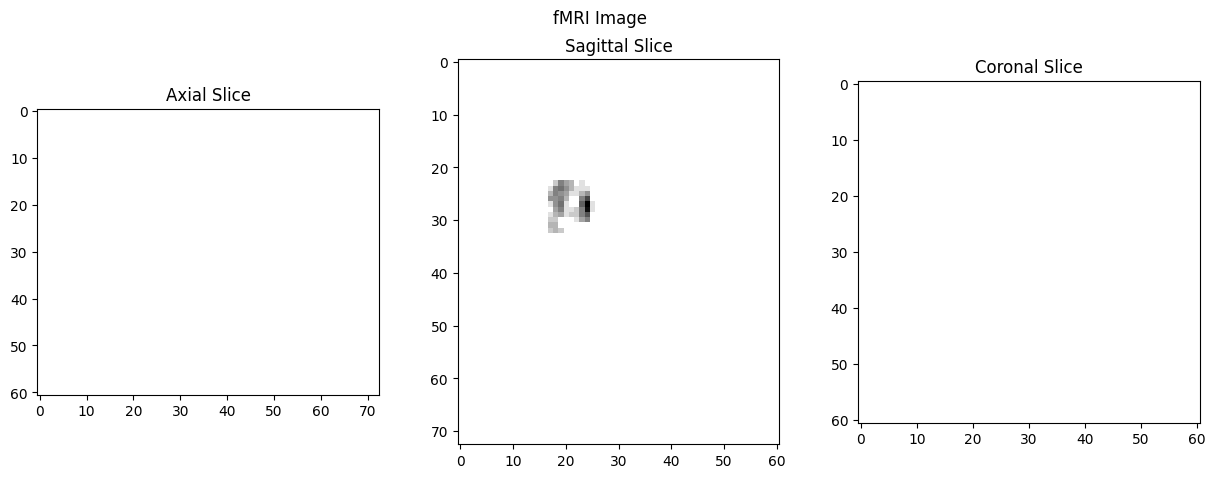

In [7]:
# Load PPA data
file_path = r"D:\UBC\Courses\Dataset\fMRI_preprocessed\sub1\roi"
file_name = "PPA_Kanwisher_nmost300.nii"
full_path = os.path.join(file_path, file_name)
fMRI_img_PPA = nib.load(full_path)

print(type(fMRI_img_PPA))
print(fMRI_img_PPA.shape)

img = fMRI_img_PPA.get_fdata()
from scipy import stats
img = stats.zscore(img)

print(type(img))
plot_fMRI_slice(img)


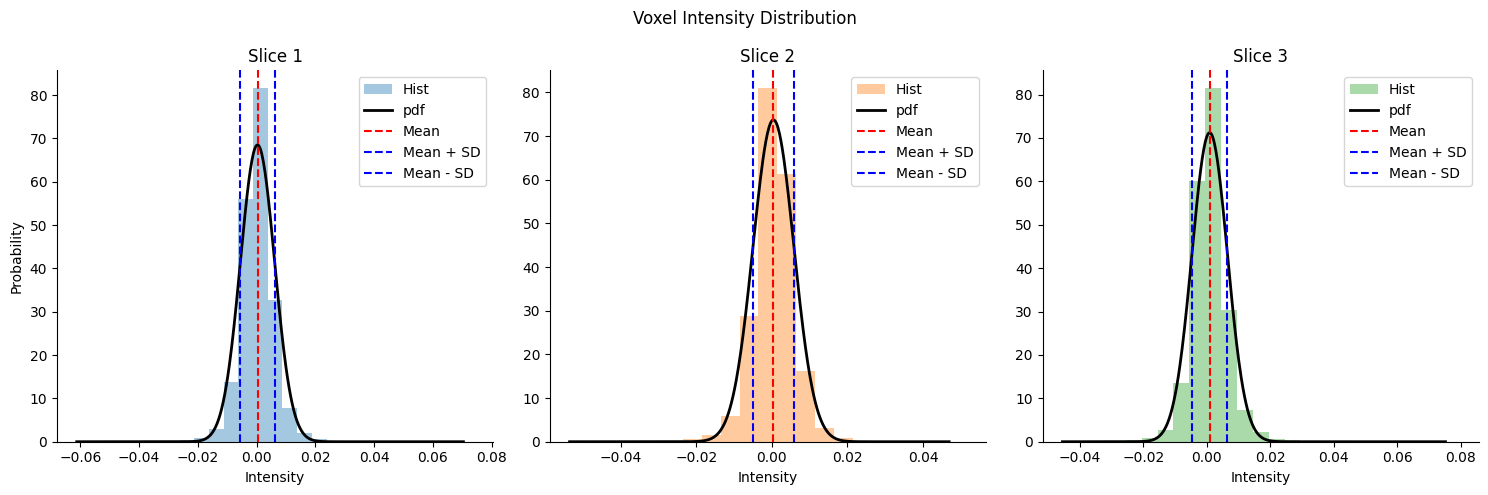

In [ ]:
# Load a subject data
from scipy.stats import norm
file_path = r"D:\UBC\Courses\Dataset\fMRI_preprocessed\sub1\PSA"
file_names = ["Image_10_beta_avg.nii", "Image_20_beta_avg.nii", "Image_30_beta_avg.nii"]
binwidth = 0.005

images = []
for file_name in file_names:
    full_path = os.path.join(file_path, file_name)
    img = nib.load(full_path).get_fdata()
    images.append(img)


fig, axes = plt.subplots(1, 3, figsize=(15,5))
means, vars = [], []

for i, ax in enumerate(axes):
    data = images[i]; mean = np.nanmean(data); var = np.nanvar(data)
    means.append(mean)
    vars.append(var)
    x = np.linspace(np.nanmin(data), np.nanmax(data), 500)
    pdf_vals = norm.pdf(x, loc = mean, scale=np.sqrt(var))
    
    bins = np.arange(np.nanmin(data), np.nanmax(data) + binwidth, binwidth)

    ax.hist(data.ravel(), bins= bins,alpha=0.4, color=f"C{i}", density=True, label = "Hist")
    ax.plot(x, pdf_vals, color="black", lw=2, label = "pdf")
    
    ax.axvline(mean, color = "red", linestyle = "--", label = "Mean")
    ax.axvline(mean + np.sqrt(var), color = "blue", linestyle = "--", label="Mean + SD")
    ax.axvline(mean - np.sqrt(var), color = "blue", linestyle = "--", label="Mean - SD")
    
    ax.set_xlabel("Intensity")
    ax.set_title(f"Slice {i+1}")
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    ax.legend()
  

axes[0].set_ylabel("Probability")
fig.suptitle("Voxel Intensity Distribution")
plt.tight_layout()


plt.show()

(61, 73, 61)


MovieWriter ffmpeg unavailable; using Pillow instead.


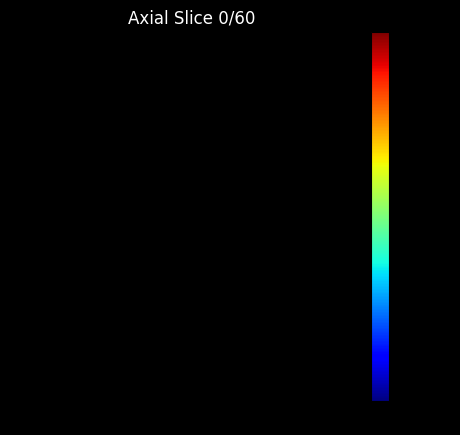

In [10]:
# Axial View
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from matplotlib.colors import Normalize

file_path = r"D:\UBC\Courses\Dataset\fMRI_preprocessed\sub1\PSA"
file_name = "Image_10_beta_avg.nii"
full_path = os.path.join(file_path, file_name)
img1_sub1 = nib.load(full_path)
print(img1_sub1.shape)
img1_sub1_np = img1_sub1.get_fdata()

axial_size = img1_sub1_np.shape[0]

fig, ax = plt.subplots(facecolor='black')
ax.set_facecolor(color='black')

img_plot = ax.imshow(img1_sub1_np[0, :, :], cmap='jet', origin='lower', vmin=np.percentile(img1_sub1_np[0, :, :],10), vmax=np.percentile(img1_sub1_np[0, :, :], 90))
title = ax.set_title(f"Axial Slice 0/{axial_size-1}", color='white')
fig.colorbar(img_plot)

def update(i):
    img_plot.set_data(img1_sub1_np[i, :, :])
    title.set_text(f"Axial Slice {i}/{axial_size-1}")
    return img_plot, title


ani = FuncAnimation(fig, update, frames=axial_size, interval=200, blit=False)
HTML(ani.to_jshtml())  
ani.save('axial_view.gif') 

MovieWriter ffmpeg unavailable; using Pillow instead.


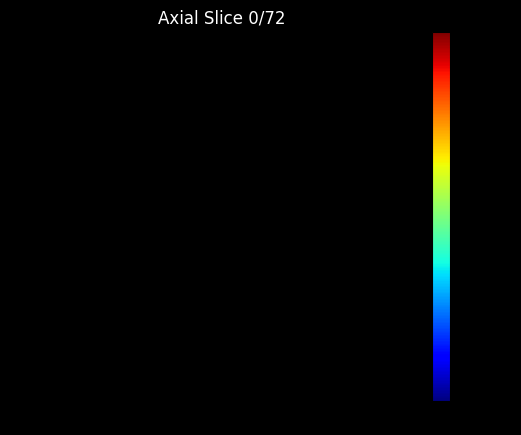

In [11]:
# Sagittal View
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from matplotlib.colors import Normalize

axial_size = img1_sub1_np.shape[1]

fig, ax = plt.subplots(facecolor='black')
ax.set_facecolor(color='black')

# Initial Image
# norm = Normalize(vmin=np.min(img), vmax=np.max(img))
img_plot = ax.imshow(img1_sub1_np[:, 0, :], cmap='jet', origin='lower', vmin=np.percentile(img1_sub1_np[:, 0, :],10), vmax=np.percentile(img1_sub1_np[:, 0, :], 90))
title = ax.set_title(f"Axial Slice 0/{axial_size-1}", color='white')
fig.colorbar(img_plot)

def update(i):
    img_plot.set_data(img1_sub1_np[:, i, :])
    title.set_text(f"Axial Slice {i}/{axial_size-1}")
    return img_plot, title

# fig.colorbar(img_plot, ax)
ani = FuncAnimation(fig, update, frames=axial_size, interval=200, blit=False)
ani.save('Sagittal_view.gif') 
HTML(ani.to_jshtml()) 

MovieWriter ffmpeg unavailable; using Pillow instead.


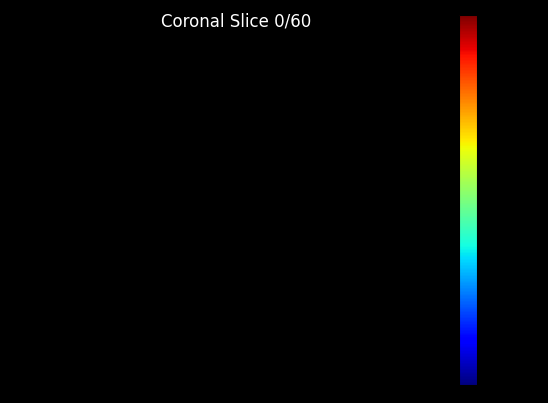

In [12]:
# Coronal View
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from matplotlib.colors import Normalize

axial_size = img1_sub1_np.shape[2]

fig, ax = plt.subplots(facecolor='black')
ax.set_facecolor(color='black')

# Initial Image
# norm = Normalize(vmin=np.min(img), vmax=np.max(img))
img_plot = ax.imshow(img1_sub1_np[:, :, 0], cmap='jet', origin='lower', vmin=np.percentile(img1_sub1_np[:, :, 0], 10), vmax=np.percentile(img1_sub1_np[:, :, 0], 90))
ax.set_title(f"Coronal Slice 0/{axial_size-1}", color="white")
fig.colorbar(img_plot)

def update(i):
    img_plot.set_data(img1_sub1_np[:, :, i])
    ax.set_title(f"Coronal Slice {i}/{axial_size-1}")
    return img_plot, ax

# fig.colorbar(img_plot, ax)
ani = FuncAnimation(fig, update, frames=axial_size, interval=200, blit=False)
ani.save('Coronal_view.gif') 
HTML(ani.to_jshtml()) 

Train Classifier

In [13]:
import os
import nibabel as nib
import tensorflow as tf
import keras
from tensorflow.keras import models
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Flatten, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
import numpy as np
from sklearn.model_selection import train_test_split
from scipy.stats import zscore

In [14]:
subjects = np.arange(42)
groups = np.array([0]*20 + [1]*22)

train_sub, test_sub, train_group, test_group = train_test_split(
    subjects, groups, test_size=0.3, random_state=42, stratify=groups
)

In [15]:
def load_group_data(sub_idx, num_stim, sub_label, stim_idx, stim_name, file_path):
    X = np.zeros((sub_idx.shape[0] * num_stim, 61, 73, 61)) # Size of bet-map: (61, 73, 61)
    y = np.zeros((sub_label.shape[0] * num_stim))
    y = np.repeat(sub_label, num_stim)
    idx = 0

    for sub in sub_idx:
        sub_folder = os.path.join(file_path, f"sub{str(sub+1)}", "PSA")
        for stim in stim_idx:
            print("Subject: {}, Stim: {}".format(sub+1, stim))
            file_name = stim_name.format(stim)
            full_path = os.path.join(sub_folder, file_name)
            
            
            bet_map = nib.load(full_path).get_fdata()
            bet_map = np.nan_to_num(bet_map)
            X[idx, :, :, :] = bet_map
            idx += 1
        zscore(X[idx-len(stim_idx):idx+1, :, :, :], axis=0)
    return X, y

In [ ]:
# plot Hist and Mean of activation for each group
# Normalize each voxel over stimulus
# Replace NaN voxeles with zero

In [16]:
# Import Data
file_path = r"D:\UBC\Courses\Dataset\fMRI_preprocessed"
stim_name = "Image_{}_beta_avg.nii"
num_stim = 64
stim_idx = list(np.arange(1, 64+1))

X_train, y_train = load_group_data(train_sub, num_stim, train_group, stim_idx, stim_name, file_path)
X_test, y_test = load_group_data(test_sub, num_stim, test_group, stim_idx, stim_name, file_path)

Subject: 27, Stim: 1
Subject: 27, Stim: 2
Subject: 27, Stim: 3
Subject: 27, Stim: 4
Subject: 27, Stim: 5
Subject: 27, Stim: 6
Subject: 27, Stim: 7
Subject: 27, Stim: 8
Subject: 27, Stim: 9
Subject: 27, Stim: 10
Subject: 27, Stim: 11
Subject: 27, Stim: 12
Subject: 27, Stim: 13
Subject: 27, Stim: 14
Subject: 27, Stim: 15
Subject: 27, Stim: 16
Subject: 27, Stim: 17
Subject: 27, Stim: 18
Subject: 27, Stim: 19
Subject: 27, Stim: 20
Subject: 27, Stim: 21
Subject: 27, Stim: 22
Subject: 27, Stim: 23
Subject: 27, Stim: 24
Subject: 27, Stim: 25
Subject: 27, Stim: 26
Subject: 27, Stim: 27
Subject: 27, Stim: 28
Subject: 27, Stim: 29
Subject: 27, Stim: 30
Subject: 27, Stim: 31
Subject: 27, Stim: 32
Subject: 27, Stim: 33
Subject: 27, Stim: 34
Subject: 27, Stim: 35
Subject: 27, Stim: 36
Subject: 27, Stim: 37
Subject: 27, Stim: 38
Subject: 27, Stim: 39
Subject: 27, Stim: 40
Subject: 27, Stim: 41
Subject: 27, Stim: 42
Subject: 27, Stim: 43
Subject: 27, Stim: 44
Subject: 27, Stim: 45
Subject: 27, Stim: 

In [17]:
print(X_train.shape)
print(train_group)

(1856, 61, 73, 61)
[1 1 0 1 0 1 0 0 1 1 1 1 0 0 0 0 0 1 1 0 1 1 1 0 1 0 1 0 0]


In [11]:
model = models.Sequential([
    Input(shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3], 1)),
    Conv3D(8, kernel_size=(5, 5, 5), activation='relu', padding= 'same'),
    MaxPooling3D(pool_size=(5, 5, 5)),
    BatchNormalization(),
    Conv3D(16, kernel_size=(3, 3, 3), activation='relu', padding= 'same'),
    MaxPooling3D(pool_size=(3, 3, 3)),
    BatchNormalization(),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

print(model.summary())

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d_2 (Conv3D)               │ (None, 61, 73, 61, 8)  │         1,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_2 (MaxPooling3D)  │ (None, 12, 14, 12, 8)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 12, 14, 12, 8)  │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_3 (Conv3D)               │ (None, 12, 14, 12, 16) │         3,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_3 (MaxPooling3D)  │ (None, 4, 4, 4, 16)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 4, 4, 4, 16)    │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 70,241 (274.38 KB)

 Trainable params: 70,193 (274.19 KB)

 Non-trainable params: 48 (192.00 B)

None


In [12]:
model.compile(
    optimizer = Adam(learning_rate=0.001),
    loss = 'binary_crossentropy',
    metrics = ['accuracy']
)

#Train the Model
history = model.fit(X_train, y_train, validation_split=0.3, epochs=10, batch_size=16)

#Evaluate the Model
test_loss, test_acc = model.evaluate(X_test, y_test)
print("Test Loss: {}, Test Accuracy: {}".format(test_loss, test_acc))

Epoch 1/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 45s 420ms/step - accuracy: 0.8212 - loss: 0.3666 - val_accuracy: 0.5404 - val_loss: 0.6898
Epoch 2/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 34s 413ms/step - accuracy: 0.9943 - loss: 0.0324 - val_accuracy: 0.5404 - val_loss: 0.7678
Epoch 3/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 38s 466ms/step - accuracy: 0.9946 - loss: 0.0219 - val_accuracy: 0.5404 - val_loss: 0.8266
Epoch 4/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 39s 480ms/step - accuracy: 1.0000 - loss: 0.0026 - val_accuracy: 0.5404 - val_loss: 1.1220
Epoch 5/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 40s 494ms/step - accuracy: 1.0000 - loss: 0.0013 - val_accuracy: 0.5404 - val_loss: 1.5702
Epoch 6/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 39s 472ms/step - accuracy: 1.0000 - loss: 9.6491e-04 - val_accuracy: 0.5440 - val_loss: 1.7904
Epoch 7/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 39s 473ms/step - accuracy: 1.0000 - loss: 6.6682e-04 - val_accuracy: 0.5566 - val_loss: 1.5367
Epoch 8/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 36s 438ms/step - accuracy: 1.0000 - loss: 5.0987e-0

In [ ]:
# class CNN(Model):
#     def __init__(self):
#         super(CNN, self).__init__()
#         self.cnv1 = Conv3D(16, kernel_size=(3, 3, 3), activation='relu')
#         self.cnv2     = Conv3D(32, kernel_size=(3, 3, 3), activation='relu')
#         self.pool1 = MaxPooling3D(pool_size=(2, 2, 2))
#         self.pool2 = MaxPooling3D(pool_size=(2, 2, 2))
#         self.batch1 = BatchNormalization()
#         self.batch2 = BatchNormalization()
#         self.flatten = Flatten()
#         self.dense1 = Dense(64, activation='relu')
#         self.dropout = Dropout(0.5)
#         self.output_layer = Dense(1, activation='sigmoid')
        
#     def call(self, input):
#         c1 = self.batch1(self.pool1(self.cnv1(input)))
#         c2 = self.batch2(self.pool2(self.cnv2(input)))
#         c3 = self.dense1(self.flatten(c2))
#         c4 = self.dropout(c3)
#         output = self.output_layer(c4)
#         return output

# # device = is    
# model = CNN()
# model.build(input_shape=(None, X.shape[0], X.shape[1], X.shape[2], 1))
# model.compile(
#     optimizer = tf.keras.optimizers.Adam()
# ) 
        

d:\UBC\Courses\Neurodata_510\neurodata_env\Lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'cnn', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


(61, 73, 61)

In [ ]:
# import numpy as np

# # Compute basic statistics
# print(f"Min intensity: {np.min(image_data)}")
# print(f"Max intensity: {np.max(image_data)}")
# print(f"Mean intensity: {np.mean(image_data)}")
# print(f"Standard deviation: {np.std(image_data)}")

# # Plot histogram of intensities
# plt.hist(image_data.ravel(), bins=50, color='blue', alpha=0.7)
# plt.title("Intensity Distribution")
# plt.xlabel("Intensity")
# plt.ylabel("Frequency")
# plt.show()


In [ ]:
# # Mask non-brain areas
# threshold = 1e-3  # Example threshold
# brain_mask = image_data > threshold

# # Visualize the masked brain
# plt.imshow(brain_mask[:, :, image_data.shape[2] // 2].T, cmap="gray", origin="lower")
# plt.title("Brain Mask (Axial Slice)")
# plt.show()


In [ ]:
# from nilearn.plotting import plot_glass_brain

# plot_glass_brain(full_path, display_mode='ortho', colorbar=True, title="3D Rendering")
